In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, to_dgl
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import rdmolfiles, rdmolops
import numpy as np
from ogb.utils.features import (allowable_features, atom_to_feature_vector,
 bond_to_feature_vector, atom_feature_vector_to_dict, bond_feature_vector_to_dict) 
from torch_geometric.explain import Explanation


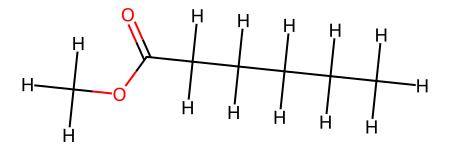

In [19]:
def smiles2graph(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    mol = Chem.AddHs(mol)
    return mol2graph(mol)

def mol2graph(mol):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """
    # mol = Chem.RemoveHs(mol)
    #print(mol)
    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append([
            atom.GetAtomicNum(),
            # int(atom.GetChiralTag()),
            atom.GetTotalDegree(),
            # atom.GetFormalCharge(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            int(atom.GetHybridization()),
            # int(atom.GetIsAromatic()),
            # int(atom.IsInRing())
        ])
    x = np.array(atom_features_list, dtype = np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype = np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype = np.int64)

    else:   # mol has no bonds
        print('Mol has no bonds :()')
        edge_index = np.empty((2, 0), dtype = np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype = np.int64)

    graph = dict()
    graph['edge_index'] = edge_index
    graph['edge_feat'] = edge_attr
    graph['node_feat'] = x
   # graph['pos'] = pos
    graph['num_nodes'] = len(x)
    graph['num_bonds'] = len(mol.GetBonds())
    return graph, mol

def prep_input(graph, pos=None, device=None):
    datalist = []
    atoms = torch.from_numpy(graph['node_feat'])
    edge_index = torch.from_numpy(graph['edge_index'])
    edge_attr = torch.from_numpy(graph['edge_feat'])
    for xyz in pos:
        data = Data(atoms=atoms, edge_index=edge_index, edge_attr=edge_attr, pos=xyz, x=atoms).to(device)
        datalist.append(data)
    return datalist


smiles = "CCCCCC(=O)OC"  # Example SMILES string
graph, mol = smiles2graph(smiles)
data = prep_input(graph, pos=torch.randn(1, 15, 3), device='cpu')
mol

In [20]:
data

[Data(x=[23, 5], edge_index=[2, 44], edge_attr=[44, 3], pos=[15, 3], atoms=[23, 5])]

In [21]:
import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s.to(dtype=torch.float),
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]


def to_rdkit(data, device=None):
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:9]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(data.pos.size(0)):
        if i in invalid_idx:
            continue
        p = Point3D(
            data.pos[i][0].item(),
            data.pos[i][1].item(),
            data.pos[i][2].item(),
        )
        conf.SetAtomPosition(node_to_idx[i], p)
    conf.SetId(0)
    mol.AddConformer(conf)

    # Convert RWMol to Mol object
    #mol = mol.GetMol()
    #mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    #largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    #mol = Chem.AddHs(mol)
    #AllChem.EmbedMolecule(mol)
   # AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [22]:
data[0].pos = torch.randn(15, 3)
mol = to_rdkit(data[0])
x = MolTo3DView(mol, size=(800, 800), style='stick', surface=False)
#x.show()

In [23]:
%%capture capdata
MolTo3DView(smi2conf(smiles), size=(800, 800), style='stick', surface=False)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

ValueError: 'c' argument has 23 elements, which is inconsistent with 'x' and 'y' with size 15.

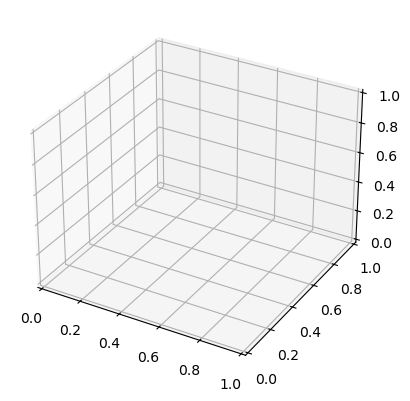

In [24]:
pos = torch.randn(1, 15, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
samples = pos.reshape(-1, 15, 3)
node_features = graph['node_feat']
num_nodes = node_features.shape[0]

# Generate a color map based on node features
colors = np.argmax(node_features, axis=1)

ax.scatter(samples[0, :, 0].cpu().numpy(), samples[0, :, 1].cpu().numpy(), samples[0, :, 2].cpu().numpy(), c=colors, s=100)
for edge in graph['edge_index'].T:
    ax.plot(samples[0, edge, 0].cpu().numpy(), samples[0, edge, 1].cpu().numpy(), samples[0, edge, 2].cpu().numpy(), color='black')
plt.show()


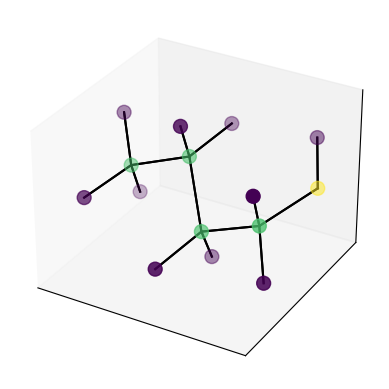

In [ ]:
pos = smi2conf(smiles).GetConformer().GetPositions()
def plot_graph(graph, pos, edge_index=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pos = pos.reshape(-1, graph['num_nodes'], 3)
    node_features = graph['node_feat']

    # Generate a color map based on node features
    colors = node_features[:, 0]

    ax.scatter(pos[0, :, 0], pos[0, :, 1], pos[0, :, 2], c=colors, s=100)
    if edge_index:
        for edge in edge_index.T:
            ax.plot(pos[0, edge, 0], pos[0, edge, 1], pos[0, edge, 2], color='black')
    else:
        for edge in graph['edge_index'].T:
            ax.plot(pos[0, edge, 0], pos[0, edge, 1], pos[0, edge, 2], color='black')

    # remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.show()
plot_graph(graph, pos)

RuntimeError: shape '[-1, 23, 3]' is invalid for input of size 45

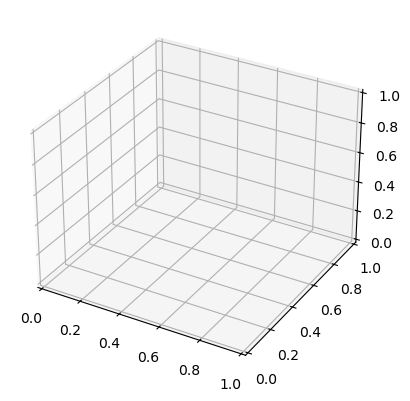

In [25]:
pos.shape
def extract_edge_indices(pos):
    edge_index_artificial = []
    for i, p1 in enumerate(pos):
        for j, p2 in enumerate(pos):
            if i == j:
                continue
            if np.linalg.norm(p1 - p2) < 1.75:
                edge_index_artificial.append([i, j])
    edge_index_artificial = np.array(edge_index_artificial).T
    return edge_index_artificial

pos = torch.randn(1, 23, 3)
edge_index_artificial = extract_edge_indices(pos)
plot_graph(graph, pos, edge_index_artificial)

In [26]:
import sys
import os 
import torch
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from models import EGNNModel, MACEModel
import json

def load_model(model, filename):
    with open(filename + '.json', 'r') as f:
        model_args = json.load(f)
        if model == 'egnn':
            model = EGNNModel(in_dim=model_args['in_dim'][0], emb_dim=model_args['emb_dim'], out_dim=model_args['out_dim'], num_layers=model_args['num_layers'], num_atom_features=model_args['in_dim'], equivariant_pred=False)
        elif model == 'mace':
            model = MACEModel(in_dim=model_args['in_dim'], emb_dim=model_args['emb_dim'], out_dim=model_args['out_dim'], num_layers=model_args['num_layers'], equivariant_pred=False)
    model.load_state_dict(torch.load(filename + '.pt'))
    return model, model_args

vac_file = '/home/radoslavralev/Documents/Thesis/gfn-diffusion/energy_sampling/weights/egnn_vacuum_small_with_hs'
sol_file = '/home/radoslavralev/Documents/Thesis/gfn-diffusion/energy_sampling/weights/egnn_solvation_small_with_hs'
vac_model, vac_args = load_model('egnn', vac_file)
sol_model, sol_args = load_model('egnn', sol_file)

In [11]:
data = prep_input(graph, pos=torch.from_numpy(pos.reshape(-3)), device='cpu')

RuntimeError: invalid shape dimension -3

In [ ]:

vac_model(data[0])

IndexError: Dimension specified as -2 but tensor has no dimensions